In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import re
import os
import ast
import wandb
import string
import numpy as np
import unicodedata
import pandas as pd
from pathlib import Path
from datasets import load_dataset
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import flash_attn
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import EarlyStoppingCallback
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import sys
sys.path.append("../../src")
sys.path.append("../../configs")
import util.preprocessing_util as util
from hf_config import hf_token

# Setup

Check versions of important packages

In [6]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Flash Attention version:", flash_attn.__version__)

PyTorch version: 2.6.0+cu124
CUDA version: 12.4
Flash Attention version: 2.7.4.post1


Check which python we are using

In [4]:
print(sys.executable)

/share/miniforge3/bin/python3.10


# Load Data

In [5]:
input_data_path = Path("../../data/dev/processed")

In [6]:
train_df = pd.read_csv(input_data_path / "pubmedqa_train.csv")
test_df = pd.read_csv(input_data_path / "pubmedqa_test.csv")

Sentences and labels are still stringified lists --> back to actual Python lists

In [7]:
# Apply literal_eval to parse strings into actual lists
train_df["sentences"] = train_df["sentences"].apply(ast.literal_eval)
train_df["labels"] = train_df["labels"].apply(ast.literal_eval)

test_df["sentences"] = test_df["sentences"].apply(ast.literal_eval)
test_df["labels"] = test_df["labels"].apply(ast.literal_eval)

In [8]:
train_df.head()

,question,sentences,labels
0,is there a functional neural correlate of indi...,[the present study tested whether individuals ...,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0]"
1,can we use the omron t9p automated blood press...,[recent events in our hospital combined with i...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ..."
2,intraabdominal vascular injury are we getting ...,[intraabdominal vascular injury iavi as a resu...,"[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, ..."
3,hand grip and pinch strength in patients with ...,[the hand grip strength test and pinch was sig...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, ..."
4,is canada ready for patient accessible electro...,[access to personal health information through...,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, ..."


# Sentence Masking

We’ll create one row per sentence: full context + label for only that sentence

And add **[START]** and **[END]** markers around the target sentence

In [9]:
WINDOW_SIZE = 2

In [10]:
train_df = util.mask_on_sentence_level(train_df, window=WINDOW_SIZE)
test_df = util.mask_on_sentence_level(test_df, window=WINDOW_SIZE)

In [11]:
train_df.head()

,question,context,target_sentence,target_index,label
0,is there a functional neural correlate of indi...,[START] the present study tested whether indiv...,the present study tested whether individuals w...,0,1
1,is there a functional neural correlate of indi...,the present study tested whether individuals w...,this study examined whether heightened cardiov...,1,0
2,is there a functional neural correlate of indi...,the present study tested whether individuals w...,heart rate variability hrv a measure of autono...,2,0
3,is there a functional neural correlate of indi...,this study examined whether heightened cardiov...,previous studies have also not controlled for ...,3,0
4,is there a functional neural correlate of indi...,heart rate variability hrv a measure of autono...,low socioeconomic status is associated with in...,4,0


# Training End-To-End

- Fine-tuning both the model weights and using a tokenizer whose vocabulary matches your task/domain.

- All components — embeddings, encoder layers, and classifier head — are updated during training.

Important Configs

In [12]:
MODEL = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
BATCH_SIZE = 64
CONTEXT_LENGTH = 512

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, token=hf_token)

In [14]:
if WINDOW_SIZE > 0:
    special_tokens = {"additional_special_tokens": ["[START]", "[END]"]}
    tokenizer.add_special_tokens(special_tokens);

Load trainable embeddings

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, num_labels=2, token=hf_token#, attn_implementation="flash_attention_2"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Resize model embeddings to match new special tokens
if WINDOW_SIZE > 0:
    model.resize_token_embeddings(len(tokenizer))

Check if model parameters are trainable (Ensure We Are Training End-to-End)

In [17]:
for param in model.parameters():
    param.requires_grad = True  # Ensure the entire model is updated

Prepare the dataset

In [18]:
dataset_train = Dataset.from_pandas(train_df)
dataset_test = Dataset.from_pandas(test_df)

In [19]:
progress_bar = tqdm(total=((len(dataset_train)+len(dataset_test))),
                    desc="Tokenizing", position=0, leave=True)

Tokenizing:   0%|          | 0/267410 [00:00<?, ?it/s]

In [20]:
def tokenize_batch(batch):
    encodings = tokenizer(
        batch["question"],
        batch["context"],
        padding="max_length",
        truncation=True,
        max_length=CONTEXT_LENGTH,
        return_tensors="pt"
    )
    return {
        "input_ids": encodings["input_ids"].tolist(),
        "attention_mask": encodings["attention_mask"].tolist(),
        "labels": batch["label"]
    }

def tokenize_with_progress(batch):
    out = tokenize_batch(batch)
    progress_bar.update(len(batch["question"]))
    return out

In [21]:
tokenized_dataset_train = dataset_train.map(tokenize_with_progress, batched=True, batch_size=BATCH_SIZE)
tokenized_dataset_test = dataset_test.map(tokenize_with_progress, batched=True, batch_size=BATCH_SIZE)

Parameter 'function'=<function tokenize_with_progress at 0x154111201d80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/237544 [00:00<?, ? examples/s]

Map:   0%|          | 0/29866 [00:00<?, ? examples/s]

In [22]:
progress_bar.close()

Convert to PyTorch Dataset (Ensure dataset is set to PyTorch format)

In [23]:
tokenized_dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Create DataLoader for Batching

In [24]:
train_dataloader = DataLoader(tokenized_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(tokenized_dataset_test, batch_size=BATCH_SIZE)

# Check one batch
batch = next(iter(train_dataloader))
print({key: value.shape for key, value in batch.items()})

{'input_ids': torch.Size([64, 512]), 'attention_mask': torch.Size([64, 512]), 'labels': torch.Size([64])}


Quick check if everything is correct before training

In [25]:
print("----- Training Set -----")
print(tokenized_dataset_train)
print(tokenized_dataset_train.column_names)
print("----- Test Set -----")
print(tokenized_dataset_test)
print(tokenized_dataset_test.column_names)

----- Training Set -----
Dataset({
    features: ['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 237544
})
['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels']
----- Test Set -----
Dataset({
    features: ['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 29866
})
['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels']


In [26]:
output_dir = Path("../../checkpoints")
output_dir.mkdir(parents=True, exist_ok=True)

# Training Configurations

Define training arguments & initialize trainer

In [27]:
NUM_EPOCHS = 3
BATCH_SIZE = 64
LEARNING_RATE = 2e-5
DATASET_NAME = "pubmedqa"

WANDB_PROJECT_NAME = "RAGBENCH-PUBMED"
WANDB_RUN_NAME = f"BioMedBert"
WANDB_NOTEBOOK_NAME = "train_sc_on_pubmed"

Setup W&B

In [28]:
os.environ["WANDB_NOTEBOOK_NAME"] = WANDB_NOTEBOOK_NAME
wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find train_sc_on_pubmed.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: flackojodye (asap) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [29]:
config = dict(
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    dataset=DATASET_NAME,
    architecture=MODEL,
    window_size=WINDOW_SIZE,
    early_stopping=True,
    eval_steps=500,
    label_smoothing_factor=0.0,
    gradient_clipping=1.0,
    load_best_model=True,
    metric_for_best_model="f1",
    input_format="question + context with [START]/[END]"
)


Generate run-id to resume same run after training 

In [30]:
run_id = wandb.util.generate_id()

In [31]:
wandb.init(
    project=WANDB_PROJECT_NAME,
    name=WANDB_RUN_NAME,
    config=config,
    id=run_id,
    resume="allow"               # resume if it exists, else start new
)

In [32]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
    }

In [33]:
training_args = TrainingArguments(
    output_dir=output_dir,                        # Where model checkpoints will be saved
    run_name=WANDB_RUN_NAME,                      # Name for W&B tracking
    learning_rate=LEARNING_RATE,                  # Base learning rate
    per_device_train_batch_size=BATCH_SIZE,       # Training batch size
    per_device_eval_batch_size=(2 * BATCH_SIZE),  # Larger eval batch size to speed up
    num_train_epochs=NUM_EPOCHS,                  # Total training epochs
    weight_decay=0.01,                            # L2 regularization
    
    # Evaluation and saving settings
    evaluation_strategy="steps",                  # Evaluate every N steps
    eval_steps=500,                               # Eval frequency
    save_strategy="steps",                        # Save checkpoints every N steps
    save_steps=500,
    
    # Logging
    logging_dir="./logs",                         # Log folder
    logging_strategy="steps",
    logging_steps=250,
    report_to="wandb",                            # Log to Weights & Biases

    # Smart checkpointing
    load_best_model_at_end=True,                  # Load the best model after training
    metric_for_best_model="f1",                   # Focus on F1 (False positives and false negatives both matter)
    greater_is_better=True,                       # Higher F1 is better

    # Optimization tweaks
    gradient_accumulation_steps=1,                # For effective batch size
    label_smoothing_factor=0.0,                   # Helps generalization for classification
    fp16=True,                                    # Mixed precision for faster training (if supported)
    gradient_checkpointing=True,                  # Reduce memory usage during training
    max_grad_norm=1.0                             # Clip gradients to avoid instability
)

/home/paul.schmitt/.local/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # Prevent overfitting by stopping when eval loss stops improving
)

Make sure we are using the GPU

In [34]:
print("GPU Available:", torch.cuda.is_available())  
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

GPU Available: True
GPU Name: NVIDIA A40


In [35]:
model.to("cuda");

In [36]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.531400,0.598380,0.702873,0.697628,0.596527,0.839993
1000,0.484000,0.584934,0.704748,0.704886,0.595207,0.864118
1500,0.465400,0.599920,0.714893,0.713830,0.604508,0.871420
2000,0.443500,0.594816,0.722025,0.715899,0.614030,0.858292
2500,0.432000,0.600581,0.718643,0.717137,0.607991,0.874046
3000,0.414500,0.578004,0.730998,0.720343,0.625537,0.849019
3500,0.412700,0.606815,0.723163,0.719957,0.613024,0.872077
4000,0.329500,0.702801,0.720284,0.717293,0.610378,0.869615
4500,0.338100,0.675738,0.725943,0.718254,0.618655,0.856076


TrainOutput(global_step=4500, training_loss=0.43851863098144533, metrics={'train_runtime': 2963.358, 'train_samples_per_second': 240.481, 'train_steps_per_second': 3.758, 'total_flos': 7.576966927835136e+16, 'train_loss': 0.43851863098144533, 'epoch': 1.2122844827586208})

Save the model (optional)

In [37]:
models_dir = Path("../../models/")
models_dir.mkdir(parents=True, exist_ok=True)

In [38]:
model.save_pretrained(models_dir)
tokenizer.save_pretrained(models_dir)

('../../models/tokenizer_config.json',
 '../../models/special_tokens_map.json',
 '../../models/vocab.txt',
 '../../models/added_tokens.json',
 '../../models/tokenizer.json')

**Check Results**

Initialize this one more time because wandb closes automatically after training

In [39]:
run = wandb.init(
    project=WANDB_PROJECT_NAME,
    id=run_id,
    resume="must"  # must resume, or error if run doesn't exist
)

eval/accuracy,▁▁▄▆▅█▆▅▇
eval/f1,▁▃▆▇▇██▇▇
eval/loss,▂▁▂▂▂▁▃█▆
eval/precision,▁▁▃▅▄█▅▅▆
eval/recall,▁▆▇▅█▃█▇▄
eval/runtime,▃▄▅▁▃█▄▃▄
eval/samples_per_second,▆▅▄█▆▁▅▆▅
eval/steps_per_second,▆▅▄█▆▁▅▆▅
train/epoch,▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇████
train/global_step,▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇████
train/grad_norm,▁▂▂▁▃▄▄▃▃▃▄▅▅▂▁▃▅█


In [40]:
results = trainer.evaluate()
df_results = pd.DataFrame([results])

In [41]:
label_names = ["Not Relevant", "Essential"]

In [42]:
df_results

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.578004,0.730998,0.720343,0.625537,0.849019,54.2167,550.863,4.316,1.212284


**Classification Report**

In [43]:
predictions = trainer.predict(tokenized_dataset_test)
preds = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids
report = pd.DataFrame(classification_report(labels, preds, output_dict=True)).transpose()
display(report)

,precision,recall,f1-score,support
0,0.861914,0.649641,0.740872,17679.000000
1,0.625537,0.849019,0.720343,12187.000000
accuracy,0.730998,0.730998,0.730998,0.730998
macro avg,0.743725,0.749330,0.730607,29866.000000
weighted avg,0.765459,0.730998,0.732495,29866.000000


In [1]:
cm = confusion_matrix(predictions.label_ids, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

NameError: name 'confusion_matrix' is not defined

**Persist Results**

In [45]:
eval_results_dir = f"./results/{WANDB_RUN_NAME}"
os.makedirs(eval_results_dir, exist_ok=True)

Locally

In [46]:
report.to_csv(os.path.join(eval_results_dir, "classification_report.csv"))

# Save Confusion Matrix 
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(eval_results_dir, "confusion_matrix.png"))
plt.close()

To Wandb

In [47]:
metrics_to_log = {
    "eval/accuracy": report.loc["accuracy", "f1-score"],
    "eval/f1_weighted": report.loc["weighted avg", "f1-score"],
    "eval/f1_class_0": report.loc["0", "f1-score"],
    "eval/f1_class_1": report.loc["1", "f1-score"],
    "eval/recall_class_0": report.loc["0", "recall"],
    "eval/recall_class_1": report.loc["1", "recall"]
}

wandb.log(metrics_to_log)
wandb.log({
    "confusion_matrix": wandb.Image(os.path.join(eval_results_dir, "confusion_matrix.png"))
})

In [48]:
wandb.finish()

eval/accuracy,▁▁
eval/f1,▁
eval/f1_class_0,▁
eval/f1_class_1,▁
eval/f1_weighted,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/recall_class_0,▁
eval/recall_class_1,▁
eval/runtime,▁


# Baseline Model

Vectorize the sentence with TF-IDF and train a logistic regression model. Fast and interpretable + a classic ML baseline

In [49]:
train_df.head()

,question,context,target_sentence,target_index,label
0,is there a functional neural correlate of indi...,[START] the present study tested whether indiv...,the present study tested whether individuals w...,0,1
1,is there a functional neural correlate of indi...,the present study tested whether individuals w...,this study examined whether heightened cardiov...,1,0
2,is there a functional neural correlate of indi...,the present study tested whether individuals w...,heart rate variability hrv a measure of autono...,2,0
3,is there a functional neural correlate of indi...,this study examined whether heightened cardiov...,previous studies have also not controlled for ...,3,0
4,is there a functional neural correlate of indi...,heart rate variability hrv a measure of autono...,low socioeconomic status is associated with in...,4,0


In [50]:
train_baseline_texts = (train_df["question"] + " [SEP] " + train_df["target_sentence"]).tolist()
test_baseline_texts = (test_df["question"] + " [SEP] " + test_df["target_sentence"]).tolist()

In [51]:
train_labels = train_df["label"].tolist()
test_labels = test_df["label"].tolist()

In [52]:
from sklearn.pipeline import Pipeline

In [53]:
baseline_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

In [54]:
baseline_pipeline.fit(train_baseline_texts, train_labels)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [55]:
test_preds = baseline_pipeline.predict(test_baseline_texts)
report = pd.DataFrame(classification_report(test_labels, test_preds, output_dict=True)).transpose()
display(report)

,precision,recall,f1-score,support
0,0.663549,0.537700,0.594032,17679.000000
1,0.474067,0.604497,0.531395,12187.000000
accuracy,0.564957,0.564957,0.564957,0.564957
macro avg,0.568808,0.571098,0.562714,29866.000000
weighted avg,0.586230,0.564957,0.568473,29866.000000


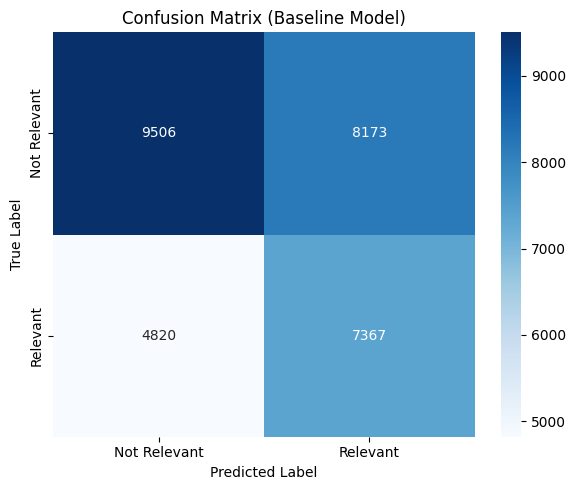

In [56]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
labels = ["Not Relevant", "Relevant"]

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Baseline Model)")
plt.tight_layout()
plt.show()

In [57]:
baseline_eval_results_dir = "./results/Baseline"
os.makedirs(baseline_eval_results_dir, exist_ok=True)

In [58]:
report.to_csv(os.path.join(baseline_eval_results_dir, "classification_report.csv"))

# Save Confusion Matrix 
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(baseline_eval_results_dir, "confusion_matrix.png"))
plt.close()